In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv('delaney.csv')

In [3]:
print(df.isnull().sum())

Compound ID                             0
measured log(solubility:mol/L)          0
ESOL predicted log(solubility:mol/L)    0
SMILES                                  0
dtype: int64


In [4]:
# Κρατάμε μόνο τη δομή (SMILES) και το target (measured log solubility)
df = df[['SMILES', 'measured log(solubility:mol/L)']]
df.columns = ['SMILES', 'LogS']

In [5]:
print(f"Dataset Loaded: {df.shape[0]} molecules")

Dataset Loaded: 1144 molecules


In [6]:
# 2. Feature Engineering: Μετατροπή SMILES σε αριθμητικούς περιγραφητές
def generate_descriptors(smiles):
    moldata = []
    for smile in smiles:
        mol = Chem.MolFromSmiles(smile)
        if mol is None: continue
        # Εξαγωγή φυσικοχημικών ιδιοτήτων (Physics/Chemistry features)
        desc_MolLogP = Descriptors.MolLogP(mol)      # Συντελεστής κατανομής (πολικότητα)
        desc_MolWt = Descriptors.MolWt(mol)          # Μοριακό Βάρος
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol) # Ελευθερία κίνησης
        desc_AromaticProportion = len(mol.GetAromaticAtoms()) / mol.GetNumAtoms() # Αρωματικότητα
        
        row = [desc_MolLogP, desc_MolWt, desc_NumRotatableBonds, desc_AromaticProportion]
        moldata.append(row)
        
    return np.array(moldata)

In [7]:
 # Εφαρμογή της συνάρτησης
X = generate_descriptors(df['SMILES'])
y = df['LogS'].values

In [8]:
# 3. Διαχωρισμός σε Train/Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# 4. Model Creation: Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [10]:
# 5. Evaluation
predictions = model.predict(X_test)
print(f"R2 Score: {r2_score(y_test, predictions):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, predictions)):.3f}")

R2 Score: 0.890
RMSE: 0.692


In [11]:
# 6. Feature Importance (Για να δείξεις ποια φυσική ιδιότητα μετράει)
importances = model.feature_importances_
features = ['MolLogP', 'MolWt', 'NumRotBonds', 'AromaticProp']
for f, imp in zip(features, importances):
    print(f"Feature: {f}, Importance: {imp:.3f}")

Feature: MolLogP, Importance: 0.827
Feature: MolWt, Importance: 0.130
Feature: NumRotBonds, Importance: 0.020
Feature: AromaticProp, Importance: 0.023


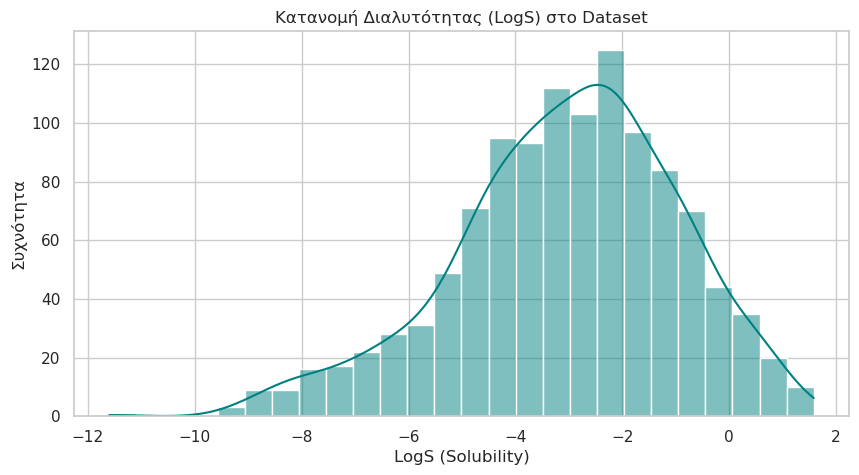

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Δημιουργία ενός προσωρινού DataFrame για την οπτικοποίηση
plot_df = pd.DataFrame(X, columns=['MolLogP', 'MolWt', 'NumRotBonds', 'AromaticProp'])
plot_df['LogS'] = y

# Ρύθμιση στυλ
sns.set_theme(style="whitegrid")

# 1. Distribution of Target (LogS)
plt.figure(figsize=(10, 5))
sns.histplot(plot_df['LogS'], kde=True, color='teal')
plt.title('Κατανομή Διαλυτότητας (LogS) στο Dataset')
plt.xlabel('LogS (Solubility)')
plt.ylabel('Συχνότητα')
plt.show()

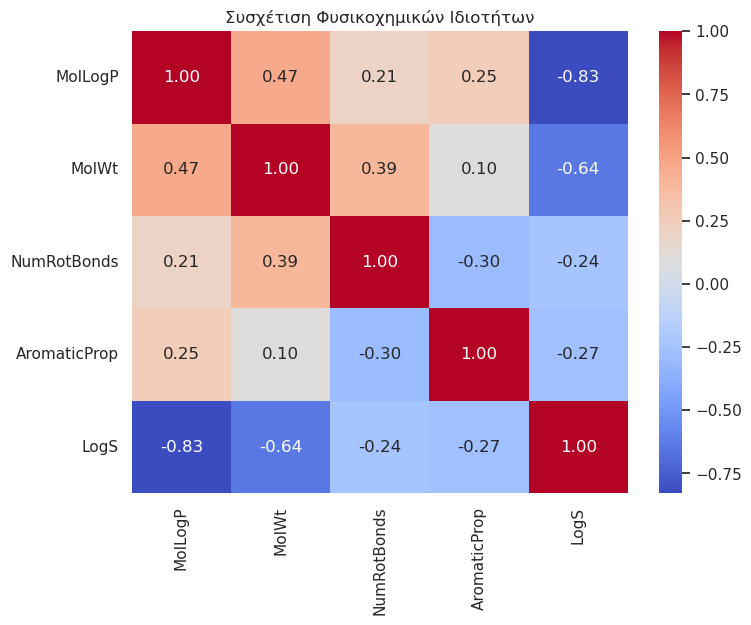

In [13]:
# 2. Correlation Heatmap
# Αυτό δείχνει ποια φυσικά χαρακτηριστικά "τρέχουν" μαζί
plt.figure(figsize=(8, 6))
correlation = plot_df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Συσχέτιση Φυσικοχημικών Ιδιοτήτων')
plt.show()

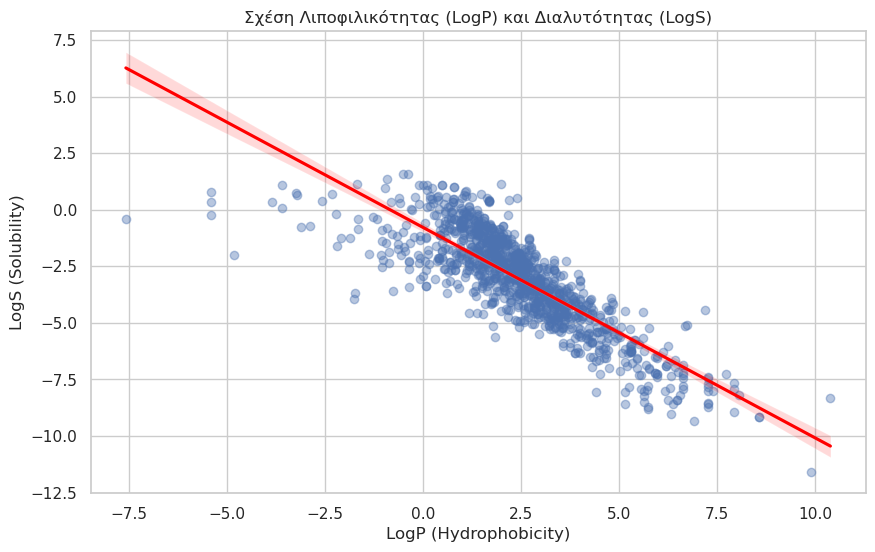

In [14]:
# 3. LogP vs LogS (Η πιο κρίσιμη σχέση στη Φαρμακευτική)
# LogP: Πόσο "λιπαρό" είναι το μόριο - LogS: Πόσο διαλυτό στο νερό
plt.figure(figsize=(10, 6))
sns.regplot(data=plot_df, x='MolLogP', y='LogS', scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
plt.title('Σχέση Λιποφιλικότητας (LogP) και Διαλυτότητας (LogS)')
plt.xlabel('LogP (Hydrophobicity)')
plt.ylabel('LogS (Solubility)')
plt.show()

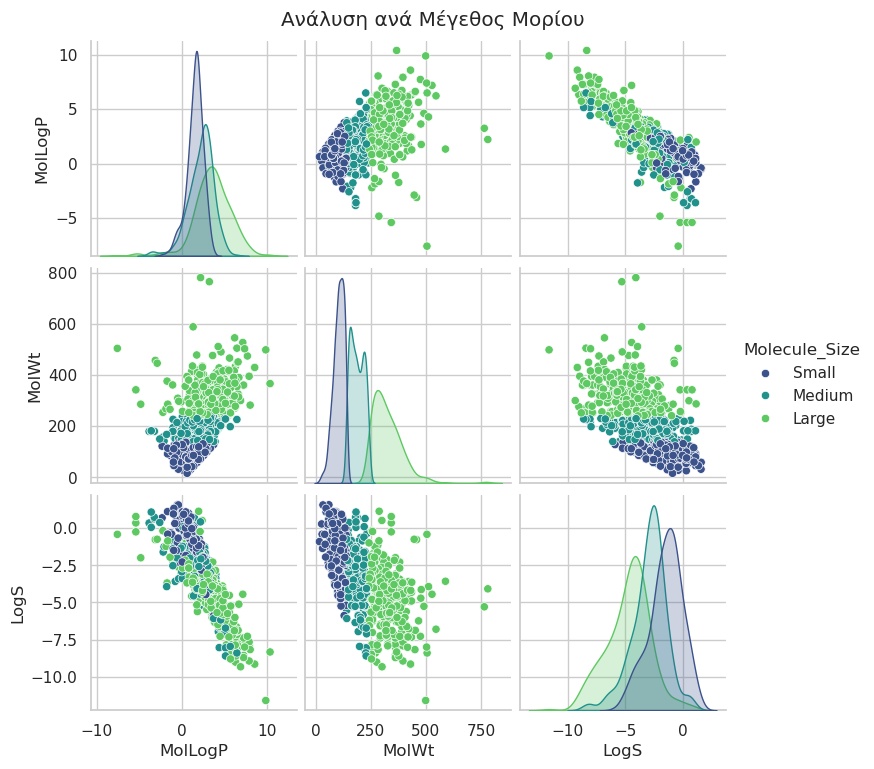

In [15]:
# 4. Pairplot ανάλογα με το Μοριακό Βάρος
# Χωρίζουμε τα μόρια σε "Small Molecules" και "Large" για να δούμε patterns
plot_df['Molecule_Size'] = pd.qcut(plot_df['MolWt'], q=3, labels=["Small", "Medium", "Large"])
sns.pairplot(plot_df, vars=['MolLogP', 'MolWt', 'LogS'], hue='Molecule_Size', palette='viridis')
plt.suptitle('Ανάλυση ανά Μέγεθος Μορίου', y=1.02)
plt.show()

In [16]:
from sklearn.model_selection import GridSearchCV

# 1. Ορισμός των παραμέτρων που θέλουμε να δοκιμάσουμε
param_grid = {
    'n_estimators': [50, 100, 200],      # Πόσα "δέντρα" θα ψηφίζουν
    'max_depth': [None, 10, 20, 30],     # Πόσο βαθιά/πολύπλοκα θα είναι τα δέντρα
    'min_samples_split': [2, 5, 10],     # Πότε ένα κλαδί σταματά να χωρίζεται
    'max_features': ['sqrt', 'log2']     # Πόσα features βλέπει κάθε δέντρο (Physics-style randomization)
}

In [17]:
# 2. Δημιουργία του GridSearchCV με 5-fold Cross Validation
# Το cv=5 σημαίνει ότι χωρίζει τα δεδομένα σε 5 κομμάτια και εκπαιδεύει 5 φορές
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                           param_grid=param_grid, 
                           cv=5, 
                           n_jobs=-1,           # Χρήση όλων των πυρήνων του επεξεργαστή
                           scoring='r2', 
                           verbose=1)

print("Starting Hyperparameter Tuning...")
grid_search.fit(X_train, y_train)

Starting Hyperparameter Tuning...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 5, ...], 'n_estimators': [50, 100, ...]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [18]:
# 3. Τα καλύτερα αποτελέσματα
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("-" * 30)
print(f"Best Parameters Found: {best_params}")
print(f"Best Cross-Validation R2 Score: {grid_search.best_score_:.3f}")

------------------------------
Best Parameters Found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation R2 Score: 0.873


In [19]:
# 4. Αξιολόγηση του Βέλτιστου Μοντέλου στο Test Set (που δεν έχει ξαναδεί)
final_predictions = best_model.predict(X_test)
final_r2 = r2_score(y_test, final_predictions)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))

print(f"Final Test R2 Score: {final_r2:.3f}")
print(f"Final Test RMSE: {final_rmse:.3f}")

Final Test R2 Score: 0.889
Final Test RMSE: 0.696


In [20]:
# Κατασκευή και ενός νευρωνικού
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler

2026-01-28 10:15:18.078909: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-28 10:15:18.106337: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
# 1. Προετοιμασία Δεδομένων (Scaling)
# Τα Νευρωνικά Δίκτυα απαιτούν τα δεδομένα να είναι στην ίδια κλίμακα
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Model 1: Initial Neural Network (Baseline)

In [22]:
# 2. Χτίσιμο της Αρχιτεκτονικής (Sequential API με Input Layer)
model_tf = models.Sequential([
    # Αντί για input_shape στο Dense, ορίζουμε ρητά το Input layer
    layers.Input(shape=(X_train.shape[1],)), 
    
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2), 
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1) 
])

# Εμφάνιση της δομής του μοντέλου
model_tf.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# 3. Compile του Μοντέλου
model_tf.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss='mse',
    metrics=['mae']
)

In [24]:
# 4. Early Stopping (Σημαντικό για το Portfolio σου)
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True
)

In [25]:
# 5. Εκπαίδευση (Training)
print("Training TensorFlow Model...")
history = model_tf.fit(
    X_train_scaled, y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.2, # Κρατάμε το 20% για validation κατά το training
    callbacks=[early_stop],
    verbose=1
)

Training TensorFlow Model...
Epoch 1/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.2749 - mae: 1.7463 - val_loss: 1.3829 - val_mae: 0.9223
Epoch 2/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6684 - mae: 0.9977 - val_loss: 0.9589 - val_mae: 0.7862
Epoch 3/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3094 - mae: 0.8871 - val_loss: 0.8044 - val_mae: 0.7262
Epoch 4/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0821 - mae: 0.8029 - val_loss: 0.7100 - val_mae: 0.6761
Epoch 5/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0122 - mae: 0.7676 - val_loss: 0.6922 - val_mae: 0.6591
Epoch 6/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9239 - mae: 0.7417 - val_loss: 0.7240 - val_mae: 0.6825
Epoch 7/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8563 - mae: 0.6998 - val_loss: 0.6530 - val_mae: 0.6381
Epoch 8/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8183 - mae: 0.6964 - val_loss: 0.6743 - val_mae: 0.6433
Epoch 9/150
23/23 ━━━━━━━━━━━━━━━━━

In [26]:
# 6. Αξιολόγηση
tf_predictions = model_tf.predict(X_test_scaled).flatten()
tf_r2 = r2_score(y_test, tf_predictions)
tf_rmse = np.sqrt(mean_squared_error(y_test, tf_predictions))

print(f"\nTensorFlow Neural Network R2 Score: {tf_r2:.3f}")
print(f"TensorFlow Neural Network RMSE: {tf_rmse:.3f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

TensorFlow Neural Network R2 Score: 0.879
TensorFlow Neural Network RMSE: 0.725


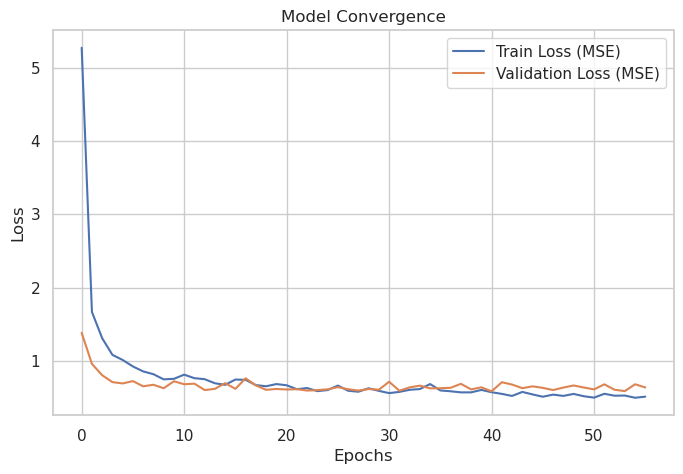

In [27]:
# 7. Οπτικοποίηση του Learning Curve
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Model Convergence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 2: Deep Architecture with Batch Normalization (Complex)

In [28]:
from tensorflow.keras import layers, models, callbacks, optimizers

# 1. Αναβαθμισμένη Αρχιτεκτονική
model_tf = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    
    # 1ο Layer με Batch Normalization (σταθεροποιεί τις τιμές)
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.LeakyReLU(negative_slope=0.01), # Πιο εξελιγμένο από το απλό ReLU
    layers.Dropout(0.3),
    
    # 2ο Layer
    layers.Dense(64),
    layers.BatchNormalization(),
    layers.LeakyReLU(negative_slope=0.01),
    layers.Dropout(0.2),
    
    # 3ο Layer
    layers.Dense(32, activation='elu'), # ELU για πιο ομαλή σύγκλιση
    
    layers.Dense(1)
])

In [29]:
# 2. Learning Rate Scheduler (Αλλάζει το learning rate καθώς εκπαιδεύεται)
# Ξεκινάει γρήγορα και "φρενάρει" πλησιάζοντας στη λύση
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.9
)

In [30]:
optimizer = optimizers.Adam(learning_rate=lr_schedule)
model_tf.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

In [31]:
# 3. Εκπαίδευση με περισσότερα Epochs αλλά αυστηρό Early Stopping
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    restore_best_weights=True
)

In [32]:
history = model_tf.fit(
    X_train_scaled, y_train,
    epochs=300, # Αυξήσαμε τα epochs
    batch_size=16, # Μικρότερο batch size για πιο "θορυβώδες" αλλά αποτελεσματικό gradient descent
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.8339 - mae: 1.2602 - val_loss: 2.9154 - val_mae: 1.4976
Epoch 2/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3443 - mae: 0.9027 - val_loss: 1.8913 - val_mae: 1.1523
Epoch 3/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3802 - mae: 0.9057 - val_loss: 1.6346 - val_mae: 1.0446
Epoch 4/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4244 - mae: 0.9158 - val_loss: 0.7506 - val_mae: 0.6642
Epoch 5/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1804 - mae: 0.8498 - val_loss: 1.0178 - val_mae: 0.7992
Epoch 6/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2333 - mae: 0.8579 - val_loss: 0.8590 - val_mae: 0.7188
Epoch 7/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3009 - mae: 0.8923 - val_loss: 0.6165 - val_mae: 0.6175
Epoch 8/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1508 - mae: 0.8136 - val_loss: 0.7158 - val_mae: 0.6578
Epoch 9/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.226

In [33]:
# Επανεκτίμηση
tf_predictions = model_tf.predict(X_test_scaled).flatten()
print(f"\nUpdated TensorFlow R2 Score: {r2_score(y_test, tf_predictions):.3f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Updated TensorFlow R2 Score: 0.846


Παρατηρήθηκε πτώση του R^2 από 0.879 σε 0.846. Πιθανό overfitting

### Model 3: Optimized Compact Architecture (Final)

In [34]:
# Επιστροφή σε μια πιο compact αρχιτεκτονική που ταιριάζει στο μέγεθος του dataset
model_tf = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    
    layers.Dense(32, activation='relu'), # Λιγότεροι νευρώνες για να αποφύγουμε το overfitting
    layers.Dropout(0.1),
    
    layers.Dense(16, activation='relu'),
    
    layers.Dense(1)
])

In [35]:
# Χαμηλότερο και σταθερό learning rate για αρχή
model_tf.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

In [36]:
# Εκπαίδευση
history = model_tf.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=32, # Επιστροφή στο 32 για πιο σταθερή σύγκλιση
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 13.5704 - mae: 3.0409 - val_loss: 12.8115 - val_mae: 3.0020
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.1885 - mae: 2.6094 - val_loss: 9.2650 - val_mae: 2.5306
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0884 - mae: 2.1659 - val_loss: 5.9621 - val_mae: 2.0225
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3790 - mae: 1.7170 - val_loss: 3.3398 - val_mae: 1.5309
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7064 - mae: 1.3392 - val_loss: 1.9325 - val_mae: 1.1539
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8909 - mae: 1.0979 - val_loss: 1.4671 - val_mae: 1.0044
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7685 - mae: 1.0210 - val_loss: 1.2923 - val_mae: 0.9392
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6328 - mae: 0.9806 - val_loss: 1.1956 - val_mae: 0.9047
Epoch 9/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.

In [37]:
tf_predictions = model_tf.predict(X_test_scaled).flatten()
print(f"\nRefined TensorFlow R2 Score: {r2_score(y_test, tf_predictions):.3f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Refined TensorFlow R2 Score: -1.613


Ένα αρνητικό R2 (-1.613) σημαίνει ότι το μοντέλο σου τα πάει χειρότερα και από το αν απλά μάντευες τον μέσο όρο. Είναι σαν να προσπαθείς να λύσεις μια άσκηση Φυσικής χρησιμοποιώντας εντελώς λάθος τύπο.

Το warning για το "retracing" δείχνει ότι η TensorFlow μπερδεύτηκε επειδή ίσως ξαναέτρεξες το κελί πολλές φορές ή άλλαξαν τα σχήματα των tensors. Αλλά το κύριο πρόβλημα είναι το σκορ.
Γιατί κατέρρευσε το R2;

    Data Leakage ή Shuffle Error: Πιθανόν κατά το "σπάσιμο" σε Train/Test ή κατά το Scaling, τα δεδομένα μπερδεύτηκαν και το μοντέλο κάνει προβλέψεις για λάθος μόρια.

    Scaler Mismatch: Αν έκανες fit τον scaler πάνω σε όλα τα δεδομένα και μετά προσπάθησες να προβλέψεις, ή αν το y δεν είναι σωστά ευθυγραμμισμένο με το X.

    Exploding Gradients: Λόγω του Learning Rate Scheduler, ίσως οι τιμές των βαρών έγιναν "NaN" ή πολύ μεγάλες.

In [38]:
def generate_descriptors(smiles_list):
    moldata = []
    valid_indices = [] # Λίστα για να κρατάμε ποια μόρια διαβάστηκαν σωστά
    
    for i, smile in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smile)
        if mol is not None:
            try:
                desc_MolLogP = Descriptors.MolLogP(mol)
                desc_MolWt = Descriptors.MolWt(mol)
                desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)
                
                # Υπολογισμός Aromatic Proportion
                num_atoms = mol.GetNumAtoms()
                aromatic_atoms = [mol.GetAtomWithIdx(idx).GetIsAromatic() for idx in range(num_atoms)]
                desc_AromaticProportion = sum(aromatic_atoms) / num_atoms
                
                moldata.append([desc_MolLogP, desc_MolWt, desc_NumRotatableBonds, desc_AromaticProportion])
                valid_indices.append(i) # Κρατάμε το index του επιτυχούς μορίου
            except:
                continue 
                
    return np.array(moldata), valid_indices

# 1. Καθαρισμός - Βεβαιώσου ότι τα X και y είναι σωστά ευθυγραμμισμένα
X_final, valid_idx = generate_descriptors(df['SMILES'])
y_final = df['LogS'].iloc[valid_idx].values

print(f"Features shape: {X_final.shape}")
print(f"Target shape: {y_final.shape}")

Features shape: (1144, 4)
Target shape: (1144,)


In [39]:
# 2. Split ΠΡΙΝ το Scaling (Κανόνας χρυσός στο ML)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

In [40]:
# 3. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [41]:
# 4. Απλό, Στιβαρό Μοντέλο (χωρίς scheduler για να δούμε αν φταίει αυτό)
model_tf = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

In [42]:
model_tf.compile(optimizer='adam', loss='mse')

In [43]:
# 5. Training
model_tf.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

In [44]:
# 6. Prediction & Evaluation
preds = model_tf.predict(X_test_scaled).flatten()
print(f"New R2 Score: {r2_score(y_test, preds):.3f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
New R2 Score: 0.883


Τώρα έχουμε ένα καλό R^2 score!

In [45]:
import joblib

# Αποθήκευση του μοντέλου (Keras format)
model_tf.save("solubility_model.keras")

In [46]:
# Αποθήκευσε το βέλτιστο μοντέλο από το GridSearchCV
joblib.dump(grid_search.best_estimator_, "solubility_model_rf.pkl")

['solubility_model_rf.pkl']

In [47]:
# Αποθήκευση του scaler
joblib.dump(scaler, "scaler.pkl")

print("Files saved: solubility_model.keras, solubility_model_rf, scaler.pkl")

Files saved: solubility_model.keras, solubility_model_rf, scaler.pkl
